In [85]:
import sys
# !{sys.executable} -m pip install fredapi
# !{sys.executable} -m pip install --upgrade pip

from fredapi import Fred
api_Key="YOUR API KEY HERE"
fred = Fred(api_key=api_Key)
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date


## Pulling the Target Series - Wilshire 5000 Total Stock Market Index since 12.31.1970

wilshire=fred.get_series_first_release('WILL5000IND')
wilshire=pd.DataFrame(wilshire)
wilshire=wilshire.fillna(method='pad')
wilshire=wilshire.resample('D').fillna(method='ffill')
wilshire.rename(columns={'value': 'Wilshire5000'}, inplace=True)
wilshire.iloc[15:,:]
toLearn=wilshire  



# Features are Added Below

# Collect All Current Release Numbers

url="https://api.stlouisfed.org/fred/releases?api_key="+api_Key+"&file_type=xml"
ra=requests.get(url)
soup=BeautifulSoup(ra.text,'html.parser')
two=re.findall('release id=".."',ra.text)
three = re.findall ('release id="..."', ra.text)

releaseIds=two+three

listReleaseIds=[]
for i in releaseIds:
    listReleaseIds.append(i)

striping=[]
for i in releaseIds:
    striping.append(i.strip('release id="'))



In [105]:
## Pull Release Function with Exception passing


limit=10
def pullReleaseE(x):
    try:
        
        release=fred.search_by_release(x,limit=limit,order_by='popularity',sort_order='desc')
        releaseIndex=release.index

        colTitles=[]
        for i in releaseIndex:
            colTitles.append(i)

        series=[]
        for i in releaseIndex:
            series.append(i)

        counting=range(1,len(series),1)

        countingList=[]
        for i in counting:
            countingList.append(i)


        for i in countingList:
            series[i]=fred.get_series_first_release(series[i])
        for i in countingList:
            series[i]=pd.DataFrame(series[i])
        for i in countingList:
            series[i]=series[i].resample('D').fillna(method='ffill')
        for i in countingList:
            series[i].rename(columns={'value': colTitles[i]}, inplace=True)

        return series
    except Exception:
        pass

In [ ]:
## Add top ten most popular data series from each FRED release to the dataframe

import random

releaseNumbers=striping
releaseNumbers=[str(i) for i in releaseNumbers]  # Get rid of 'u' 

releases=[]
for i in releaseNumbers:
    releases.append(i)

# randomReleases.append(random.choice(releaseNumbers))  ## Select a single random release
   
releases=list(map(int, releases)) 


for i in releases:
    newSeries=pullReleaseE(i)    
    
    counting=range(1,10,1) ##len(newSeries)
    
    countingList=[]
    for i in counting:
        countingList.append(i)

    # for i in countingList:
    #     toLearn=toLearn.join(newSeries[i],how='outer')

    for i in countingList:    # The above with try: except: language
        try:
            toLearn=toLearn.join(newSeries[i],how='outer')
        except:
                continue

In [98]:
## Forward fill a maximum of 99 days and Remove any column that has any NaN in the period form 1971 to Present

fullFrame=toLearn['1971-01-01':date.today()]
fullFrameFfill=fullFrame.fillna(method="ffill", limit=99)

fullFrame0=fullFrameFfill.fillna(0,inplace=False)
fullFrameClean=fullFrame0.loc[:, (fullFrame0==0).any(axis=0)==False] ## Delete all Columns with any 0s after 1971-01-01

Iteration 1, loss = 0.17616989
Validation score: 0.428515
Iteration 2, loss = 0.01394051
Validation score: 0.883837
Iteration 3, loss = 0.00540185
Validation score: 0.917540
Iteration 4, loss = 0.00444703
Validation score: 0.930525
Iteration 5, loss = 0.00393887
Validation score: 0.939350
Iteration 6, loss = 0.00356363
Validation score: 0.946353
Iteration 7, loss = 0.00325739
Validation score: 0.953217
Iteration 8, loss = 0.00298587
Validation score: 0.958639
Iteration 9, loss = 0.00275195
Validation score: 0.963014
Iteration 10, loss = 0.00255754
Validation score: 0.968237
Iteration 11, loss = 0.00238354
Validation score: 0.972061
Iteration 12, loss = 0.00224038
Validation score: 0.974498
Iteration 13, loss = 0.00212701
Validation score: 0.977772
Iteration 14, loss = 0.00202678
Validation score: 0.979957
Iteration 15, loss = 0.00194148
Validation score: 0.981838
Iteration 16, loss = 0.00186121
Validation score: 0.982858
Iteration 17, loss = 0.00181638
Validation score: 0.984139
Iterat

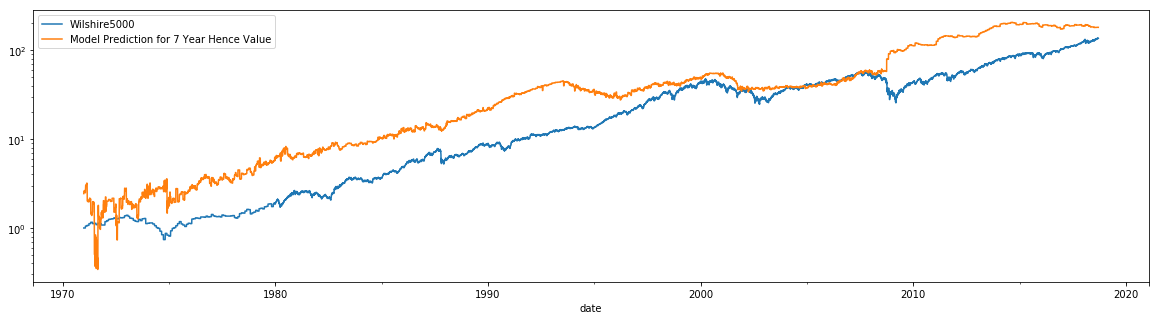

In [104]:
#Prepare to Learn

# Define a Subset of the Dataframe to Learn 

trainSubset=fullFrameClean['1971-01-01':'2003-01-01']  #
testSubset=fullFrameClean['2003-01-01':date.today()]    #            

#Randomly Sample Learning Subset

NtrainSamples=int(  round(1 * len(trainSubset) ) )  

trainSamples=pd.DataFrame.sample(trainSubset,n=NtrainSamples,replace=True,axis=0)


# Scale the Training Samples

from sklearn.preprocessing import MinMaxScaler

scalerForXtrain = MinMaxScaler()
scalerForXtrain.fit(trainSamples)
trainSamplesScaled=scalerForXtrain.transform(trainSamples)

#Put Train Samples back in a Dataframe

trainSamplesScaledDF=pd.DataFrame(trainSamplesScaled,index=trainSamples.index.values)

#Add Feature Names back to Scaled Train Data

col_titles=[]
for i in fullFrameClean:       
    col_titles.append(i)   
trainSamplesScaledDF.columns = col_titles


X_Train=trainSamplesScaledDF


#### The Target
# Find Target 7 years after Each Training Sample 

indicesOfTrainSamples=trainSamples.index
indicesOfTarget=indicesOfTrainSamples + pd.Timedelta(weeks=7*52)

targetRows=[]
for i in indicesOfTarget:
     targetRows.append(fullFrameClean.loc[i])    #

targetRows=pd.DataFrame(targetRows,index=indicesOfTarget)
target=targetRows['Wilshire5000']    ## Select Target from Rows of Target Dates

#Normalize Target Feature

scalerForYtrain=MinMaxScaler()
target=target.values.reshape(-1,1)
scalerForYtrain.fit(target)


targetScaled=scalerForYtrain.transform(target)

#Put Target Feature in a Data Frame

targetScaledDF=pd.DataFrame(targetScaled,index=targetRows.index)
col_title=['Wilshire5000']
targetScaledDF.columns=col_title


Y_Train=targetScaledDF
Y_Train=np.ravel(Y_Train,order='C')


n=round( len(fullFrameClean.columns)/1 )   #




#### Make the Classifier and Learn
from sklearn.neural_network import MLPRegressor
clf=MLPRegressor(verbose=True, early_stopping=True, validation_fraction=0.25, max_iter=100,hidden_layer_sizes=(n,n,n),alpha=.01)


clf.fit(X_Train,Y_Train)


### Use Classifer to Predict the Train and Test of toLearn Dataframe


# Transform fullFrameClean using X Train Scaler

fullFrameScaledByXtrainScaler=scalerForXtrain.transform(fullFrameClean)   #


# Put into an array


predictionArray=np.array(fullFrameScaledByXtrainScaler)
predictions=clf.predict(predictionArray)
predictions=predictions.reshape(-1,1)
predictions=scalerForYtrain.inverse_transform(predictions)
predictionsFlattened=list(predictions.flatten())

#  Create  Graphable Object


index=fullFrame0.index.values    #
predictionsDF=pd.DataFrame(predictionsFlattened,index=index)
targetDF=pd.DataFrame(fullFrameClean['Wilshire5000'])


predictionsWithActual=targetDF.join(predictionsDF, how='outer') 


predictionsWithActual.columns = ['Wilshire5000','Model Prediction for 7 Year Hence Value']

# Graphing

plt.rcParams["figure.figsize"] = (20,5)
predictionsWithActual.plot()
plt.yscale('log')
plt.show()